# Análisis y Reporte sobre el desempeño del modelo

El dataset utilizado en esta implementación es *Diabetes Dataset* y se puede encontrar en https://www.kaggle.com/datasets/mathchi/diabetes-data-set. En este mismo sitio se puede consultar una breve descripción del mismo.

En este caso se implementó un **clasificador de árbol de decisión**, cuyo propósito es predecir, en base a medidas diagnósticas, si un paciente tiene diabetes o no. Por lo tanto, este problema puede ser considerado como de clasificación.

Este modelo fue realizado por: **Arturo Garza Campuzano**, miembro del equipo 7 del curso TC3006C.101.

## Importar módulos

In [ ]:
# Uso general
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Division en subconjuntos de train, test & validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Modelo
from sklearn.tree import DecisionTreeClassifier
# Refinamiento
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
# Analisis de desempeno
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Cargar datos

In [ ]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
diabetes_df = pd.read_csv('/content/drive/MyDrive/TC3006C101_A00828096/Aprendizaje_Maquina/diabetes.csv')

#Descripcion de datos
cantidad_registros = len(diabetes_df)
numero_caracteristicas = len(diabetes_df.columns) - 1
valores_salida = diabetes_df["Outcome"].unique()
print("Descripcion de Diabetes Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: {valores_salida}")

Mounted at /content/drive
Descripcion de Diabetes Dataset
Cantidad de registros: 768
Número de características: 8
Valores de salida: [1 0]


## Limpieza del conjunto

El valor cero no es aceptable para algunas variables. Se reemplazan estos valores con la media respectiva a cada variable.

In [ ]:
# Se reemplazan los ceros por la media de las variables
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', "Insulin"]

for column in zero_not_accepted:
  diabetes_df[column] = diabetes_df[column].replace(0, np.NaN)
  mean = int(diabetes_df[column].mean(skipna = True))
  diabetes_df[column] = diabetes_df[column].replace(np.NaN, mean)

## Separación de datos en subconjuntos

Se divide el conjunto de datos en entrenamiento, prueba y validación.

In [ ]:
# Seleccion de columnas de train_df
n = len(diabetes_df.columns) - 1
X = diabetes_df.iloc[:, 0:n]
y = diabetes_df.iloc[:, n]

# Dividir el dataset en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Cualquier algoritmo en el que se calcula la distancia o se asume normalidad, los atributos se escalan. En este caso, se asume la normalidad de los datos y, por lo tanto, se escalan.

In [ ]:
# Escalamiento de variables
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

In [ ]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.682292,72.386719,29.108073,155.28125,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.435999,12.096642,8.791221,85.02155,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.00000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.50000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,155.00000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.00000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.00000,67.100000,2.420000,81.000000,1.000000


## Entrenamiento del modelo

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define una lista de valores para max_depth, min_samples_split, min_samples_leaf, criterion y max_features
max_depth_values = range(5, 51, 5)
min_samples_split_values = range(10, 101, 10)
min_samples_leaf_values = range(1, 11, 1)  # Puedes ajustar este rango según lo necesites
criterion_values = ['entropy', 'gini']
max_features_values = ['sqrt', 'log2', None]

# Crea un diccionario con los hiperparámetros que deseas ajustar
param_grid = {
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values,
    'criterion': criterion_values,
    'max_features': max_features_values
}

# Crea un árbol de decisión con algunos hiperparámetros fijos
tree = DecisionTreeClassifier(random_state=42)

# Crea un objeto GridSearchCV para realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajusta el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Obtiene los mejores hiperparámetros encontrados
best_params = grid_search.best_params_

# Imprime los mejores hiperparámetros
print("Mejores hiperparámetros:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Crea un árbol de decisión con los mejores hiperparámetros
best_tree = DecisionTreeClassifier(**best_params)

# Ajusta el modelo con los mejores hiperparámetros a tus datos de entrenamiento
best_tree.fit(X_train, y_train)

Mejores hiperparámetros:
criterion: entropy
max_depth: 10
max_features: sqrt
min_samples_leaf: 8
min_samples_split: 60


DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=60)

In [20]:
best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=60, min_impurity_decrease=0.02)

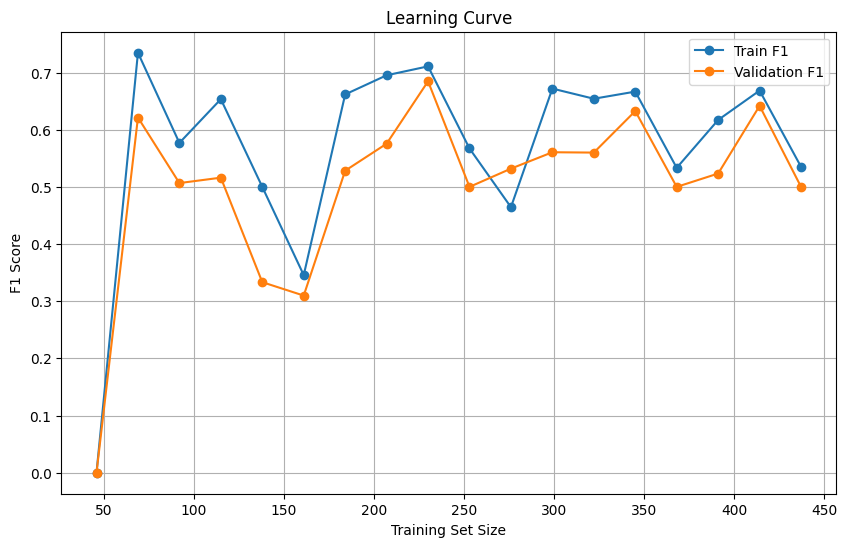

In [21]:
# Define a list of training set sizes you want to use
train_set_sizes = np.arange(0.1, 1.0, 0.05)  # For example, use 10%, 20%, ..., 100% of the training data

# Lists to store training and validation F1 scores
train_f1_scores = []
validation_f1_scores = []

# Loop through different training set sizes
for train_size in train_set_sizes:
    # Calculate the number of samples based on the percentage
    num_samples = int(train_size * len(X_train))

    # Subset the training data
    X_train_subset, y_train_subset = X_train[:num_samples], y_train[:num_samples]

    # Fit the model on the training subset
    best_tree.fit(X_train_subset, y_train_subset)

    # Predict on the training and validation sets
    y_train_pred = best_tree.predict(X_train_subset)
    y_validation_pred = best_tree.predict(X_val)

    # Calculate the F1 score for training and validation
    train_f1 = f1_score(y_train_subset, y_train_pred)
    validation_f1 = f1_score(y_val, y_validation_pred)

    # Append F1 scores to the lists
    train_f1_scores.append(train_f1)
    validation_f1_scores.append(validation_f1)

# Plot the learning curve with F1 scores
plt.figure(figsize=(10, 6))
plt.plot(train_set_sizes * len(X_train), train_f1_scores, label='Train F1', marker='o', linestyle='-')
plt.plot(train_set_sizes * len(X_train), validation_f1_scores, label='Validation F1', marker='o', linestyle='-')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
y_train_pred = best_tree.predict(X_train)
y_validation_pred = best_tree.predict(X_val)

# Calcular la métrica F1 promedio en los conjuntos de entrenamiento y validación
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_validation_pred)

# Diagnóstico del sesgo y la varianza
if train_mse < val_mse:
    print("Sesgo: Bajo")
else:
    print("Sesgo: Medio o Alto")

if abs(train_mse - val_mse) < 0.01:
    print("Varianza: Baja")
else:
    print("Varianza: Media o Alta")

# Diagnóstico del nivel de ajuste del modelo
if train_mse < val_mse:
    print("El modelo está sobreajustado (overfitting)")
elif train_mse > val_mse:
    print("El modelo está subajustado (underfitting)")
else:
    print("El modelo está bien ajustado")

Sesgo: Medio o Alto
Varianza: Baja
El modelo está subajustado (underfitting)


## Análisis de desempeño

In [ ]:
def metricas_desempeno(y, y_pred):
  confusion_matrix_results = confusion_matrix(y, y_pred)
  accuracy_score_results = accuracy_score(y, y_pred)
  precision_score_results = precision_score(y, y_pred)
  recall_score_results = recall_score(y, y_pred)
  f1_score_results = f1_score(y, y_pred)
  return confusion_matrix_results, accuracy_score_results, precision_score_results, recall_score_results, f1_score_results

# Metricas de desempeno para subconjunto de entrenamiento
y_pred_train = best_tree.predict(X_train)
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, y_pred_train)

# Metricas de desempeno para subconjunto de prueba
y_pred_test = best_tree.predict(X_test)
confusion_matrix_test, accuracy_score_test, precision_score_test, recall_score_test, f1_score_test = metricas_desempeno(y_test, y_pred_test)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Test': [accuracy_score_test, precision_score_test, recall_score_test, f1_score_test]
})

metrics_df

,Metric,Train,Test
0,Accuracy,0.797826,0.720779
1,Precision,0.774436,0.591837
2,Recall,0.620482,0.557692
3,F1 Score,0.688963,0.574257
